# Mahfuz Rahman
##Student No.: 217847518
### EECS4421 Lab 7



---



1. First, develop a tool in python that reads in a json file describing a collection of circular objects. Assume that they all exist in a rectangular world of some known maximum size (0..999, 0..999) would seem like a good size. You should have code from an earlier exercise in the course that may be helpful here.

In [36]:
import cv2
import numpy as np
import json
import random
import math

### Please replace cv2_imshow with cv2.imshow if running anywhere else other then Google Colab
from google.colab.patches import cv2_imshow

# Constants for the world bounds
WORLD_WIDTH = 999
WORLD_HEIGHT = 999

N = 100  # Number of random samples
BACKGROUND_COLOR = (255, 255, 255)  # White background
OCCUPIED_COLOR = (0, 0, 0)  # Black for obstacles

In [ ]:
def load_json(filename):
    """Load and parse the JSON file."""
    with open(filename, 'r') as file:
        data = json.load(file)
    return data

def validate_circles(data):
    """Validate circle data to ensure they fit within the world boundaries."""
    valid_circles = []
    for circle in data.get("circles", []):
        x, y, radius = circle.get("x"), circle.get("y"), circle.get("radius")
        if x is None or y is None or radius is None:
            print(f"Invalid circle data: {circle}")
            continue
        # Check if the circle stays within world bounds
        if (0 <= x - radius <= WORLD_WIDTH and 0 <= x + radius <= WORLD_WIDTH and
            0 <= y - radius <= WORLD_HEIGHT and 0 <= y + radius <= WORLD_HEIGHT):
            valid_circles.append(circle)
        else:
            print(f"Circle {circle} is out of bounds and will be ignored.")
    return valid_circles

In [ ]:
# Load and validate circles from the JSON file
data = load_json("circles.json")
circles = validate_circles(data)



---



2. Write code that uses opencv to create a colour image of the same size as your world, fills it with white, and then draws the circles from the map. That is, draw the map on the screen. But keep this array. Note that occupied locations have a value that is not white (255,255,255).

In [ ]:
def draw_circles_on_map(circles):
    """Create an image, fill it with white, and draw circles on it."""
    # Create a white background image
    world = np.full((WORLD_HEIGHT, WORLD_WIDTH, 3), BACKGROUND_COLOR, dtype=np.uint8)

    # Draw each valid circle on the image
    for circle in circles:
        x, y, radius = circle["x"], circle["y"], circle["radius"]
        cv2.circle(world, (x, y), radius, OCCUPIED_COLOR, -1)  # Draw filled obstacle circle

    return world

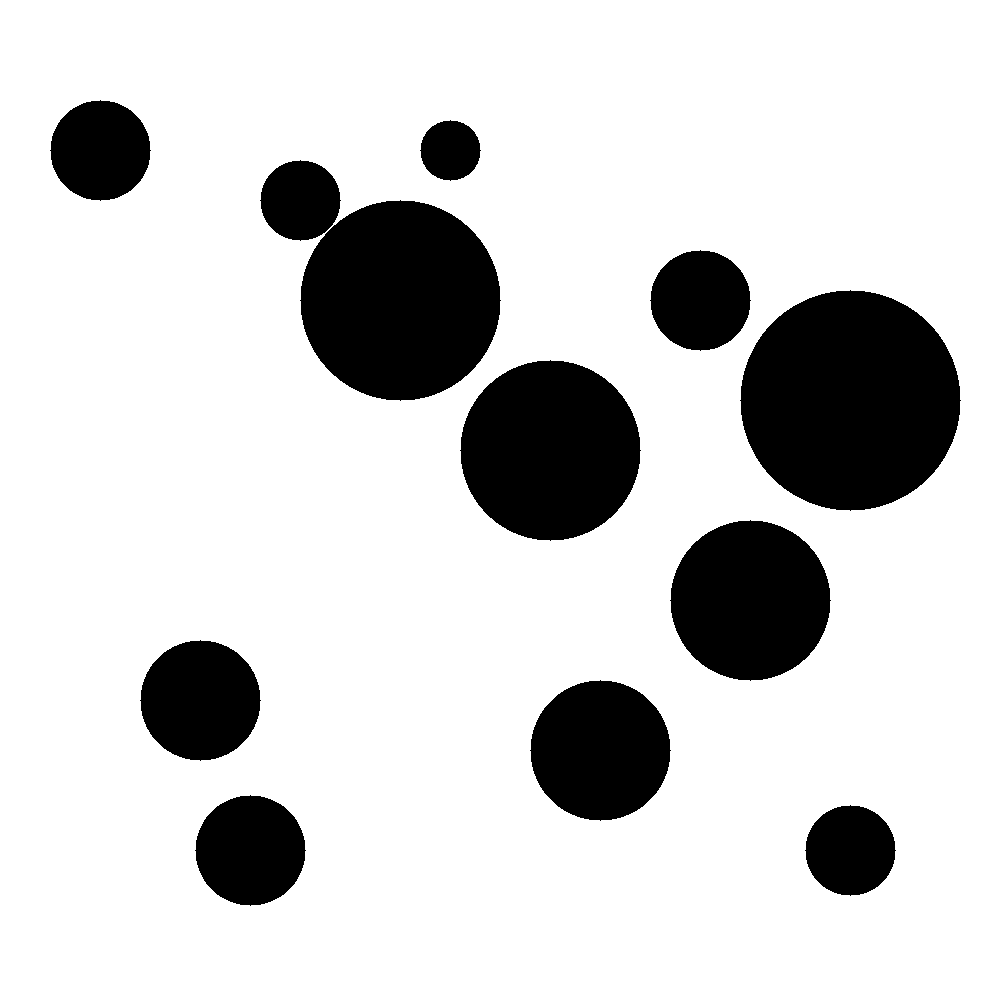

In [ ]:
# Create the world image with obstacles
world = draw_circles_on_map(circles)
cv2_imshow(world)



---



3. RRT consists of two phases. Phase 1 is to randomly seed the world with possible nodes from the RRT. N times (N=100), choose a random (x,y) coordinate in your world and check to see if it is occupied. The easy way of doing this is to check to see if the corresponding location is black (0,0,0) in the array. Create a copy of the 'occupied' image and draw these random points in this image as red (0,0,255) or green (0,255,0) depending on if the sample point is in an obstacle. Keep a list of all of the points that are not in an obstacle. Display the image with the sample points.

In [ ]:
def seed_random_points(world, num_samples):
    """Randomly seed the world with points and mark them based on occupancy."""

    world_with_points = world.copy()  # Create a copy of the world image
    # List to hold points that are not in an obstacle
    free_points = []

    for _ in range(num_samples):
        # Generate random (x, y) coordinates
        x = random.randint(0, WORLD_WIDTH - 1)
        y = random.randint(0, WORLD_HEIGHT - 1)

        # Check if the point is in an obstacle by seeing if it's black
        if np.array_equal(world_with_points[y, x], OCCUPIED_COLOR):  # Obstacle check
            cv2.circle(world_with_points, (x, y), 3, (0, 0, 255), -1)  # Mark as red if in obstacle
        else:
            cv2.circle(world_with_points, (x, y), 3, (0, 255, 0), -1)  # Mark as green if free
            free_points.append((x, y))  # Add to free points list

    # Display the image with sample points
    cv2_imshow(world_with_points)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return world_with_points, free_points

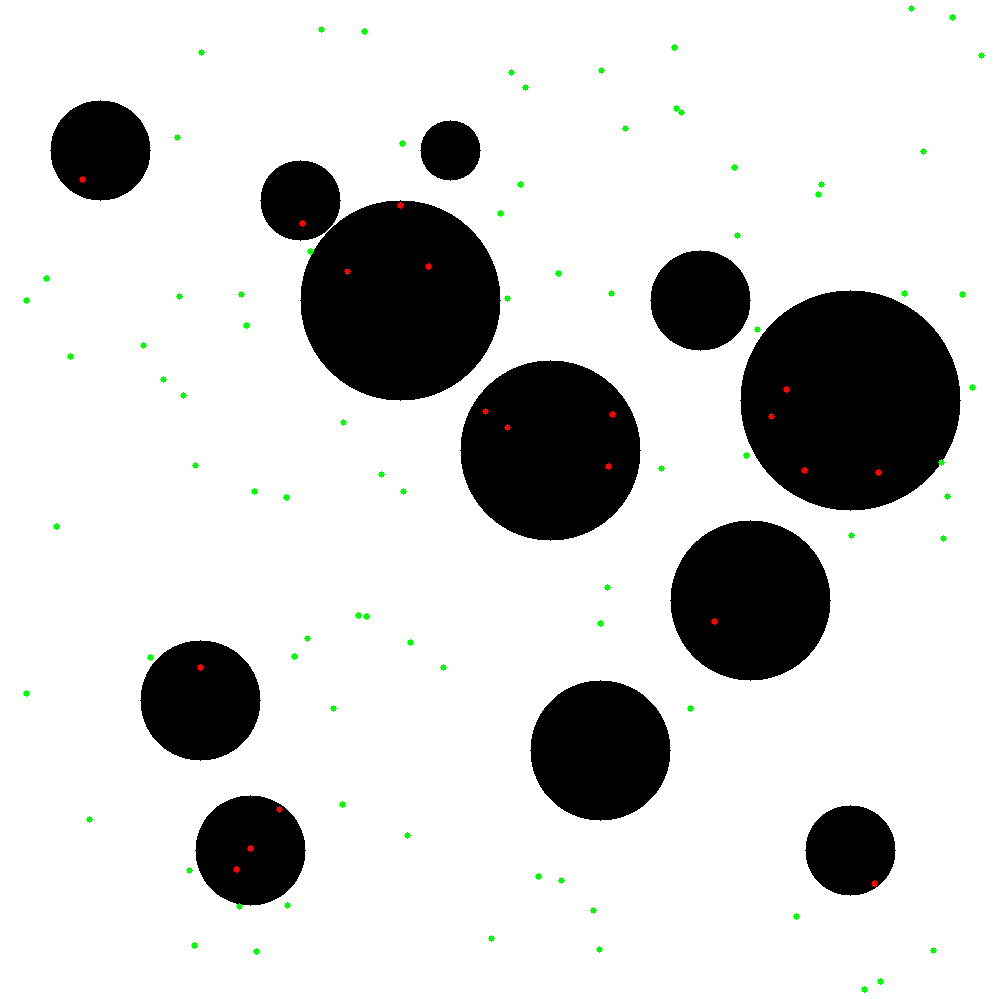

In [ ]:
# Seed random points and retrieve free points
world_with_points, free_points = seed_random_points(world, N)



---



4. Grow the tree. Choose one of the points as the root of the tree. Then for every other point, try to connect it with a straight line from it to the closest node in the tree. If it makes it to the tree, draw the line in your display image created above, and add the node to the tree. Otherwise discard.


In [ ]:
def is_line_free(world, point1, point2, step_size=1):
    """Check if the line between two points is free of obstacles."""
    x1, y1 = point1
    x2, y2 = point2

    # Calculate the total distance between the points
    distance = math.dist(point1, point2)

    # Calculate the number of steps based on the step size
    num_steps = int(distance / step_size)

    # Calculate the increments for each step
    x_step = (x2 - x1) / num_steps
    y_step = (y2 - y1) / num_steps

    # Iterate through each step along the line
    for i in range(num_steps + 1):  # +1 to include the endpoint
        # Calculate the current point along the line
        x = int(x1 + i * x_step)
        y = int(y1 + i * y_step)

        # Check if the current point is within an obstacle
        if np.array_equal(world[y, x], [0, 0, 0]):  # Black indicates an obstacle
            return False

    # If no obstacles were encountered, return True
    return True


def grow_rrt(world, free_points):
    """Grow the RRT tree by connecting free points."""

    tree_image = world.copy()  # Create a copy of the world image for the tree

    # Choose a random point as the root
    root = random.choice(free_points)
    tree = [root]
    edges = []  # List to store edges between nodes

    for point in free_points:
        if point == root:
            continue

        # Find the nearest point in the tree to this point
        nearest_point = min(tree, key=lambda node: math.dist(node, point))

        # Check if a straight line can connect without crossing obstacles
        if is_line_free(tree_image, nearest_point, point):
            cv2.line(tree_image, nearest_point, point, (0, 255, 0), 1)  # Green line for connection
            tree.append(point)
            edges.append((nearest_point, point))

    # Display the final tree image
    cv2_imshow(tree_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return tree, edges, tree_image

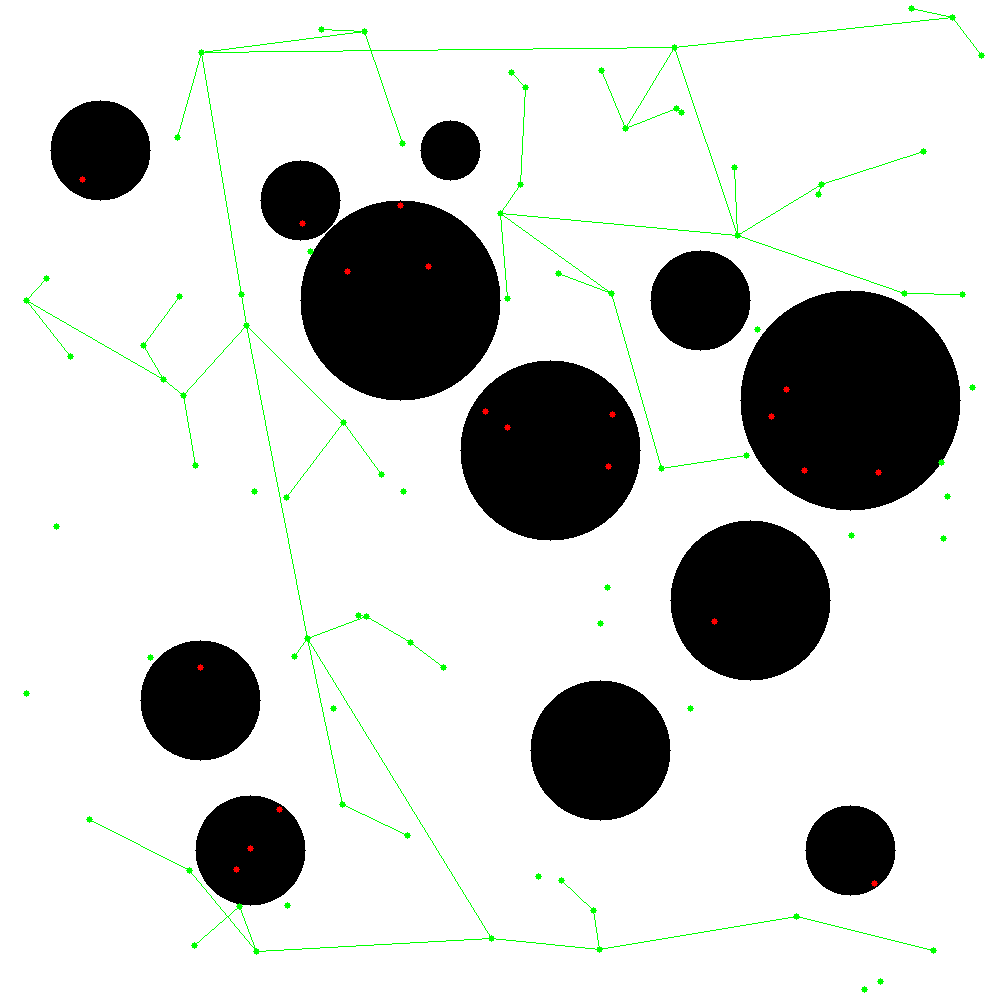

In [ ]:
# Grow the RRT tree from the free points and display it
tree, edges, tree_image = grow_rrt(world_with_points, free_points)



---



5. You now have a tree that spans a reasonable amount of the space of the world. As a bonus, given a start and a goal, you join the start and goal to the tree using an approach similar to the approach for growing the tree, but try each node in the tree as a possible joining point, not just the closest. Then use a shortest path in a tree algorithm to find a path from the start to the goal.


In [54]:

def find_shortest_path(edges, start, goal):
    """Find the shortest path in the tree from start to goal using BFS."""
    from collections import deque, defaultdict

    # Build an adjacency list for the tree
    adj_list = defaultdict(list)
    for u, v in edges:
        adj_list[u].append(v)
        adj_list[v].append(u)

    # BFS to find the shortest path
    queue = deque([[start]])
    visited = set([start])
    while queue:
        path = queue.popleft()
        node = path[-1]
        if node == goal:
            return path
        for neighbor in adj_list[node]:
            if neighbor not in visited:
                visited.add(neighbor)
                queue.append(path + [neighbor])
    return None

def calculate_path_length(path):
    """Calculate the total length of a path given a list of (x, y) coordinates."""
    total_length = 0
    for i in range(len(path) - 1):
        # Calculate the Euclidean distance between consecutive points
        x1, y1 = path[i]
        x2, y2 = path[i + 1]
        distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        total_length += distance
    return total_length

def draw_path(world, path, imageName):

    for i in range(len(path) - 1):
        start_point = path[i]
        end_point = path[i + 1]
        cv2.line(world, start_point, end_point, (0, 0, 255), 1)

    # Display the image
    # cv2_imshow(world)
    # print(" \n")
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    filename = f"output_path_step_{imageName}.jpeg"
    cv2.imwrite(filename, world)


def connect_start_and_goal(world, tree, edges, start, goal):
    """Attempt to connect the start and goal to the tree."""

    imageName = 0
    image = world.copy()

    shortest_path_length = float('inf')
    shortest_path = None

    for node1 in tree:
        edges_1 = edges.copy()

        if is_line_free(image, start, node1):
            edges_1.insert(0, (start, node1))

            for node2 in tree:
                edges_2 = edges_1.copy()

                if is_line_free(image, goal, node2):
                    edges_2.append((goal, node2))

                    path = find_shortest_path(edges_2, start, goal)

                    path_length = calculate_path_length(path)


                    if path_length < shortest_path_length:
                        shortest_path_length = path_length
                        shortest_path = path

                        draw_path(image, path, imageName)  # Draw the path
                        imageName += 1

    return shortest_path

In [58]:
connected_image = tree_image.copy()

start = (100, 800)
goal = (850, 100)

cv2.circle(connected_image, start, 6, (0, 165, 255), -1) #Orange
cv2.circle(connected_image, goal, 6, (255, 192, 203), -1) #Pink

# Connect start and goal
path  = connect_start_and_goal(connected_image, tree, edges, start, goal)

draw_path(connected_image, path, "final")

filename = f"output_path_step_final.jpeg"
cv2.imwrite(filename, connected_image)


cv2.waitKey(0)
cv2.destroyAllWindows()

> My algorithm connects the start and goal points for every permutations with the nodes in the tree I created earlier. I then use the path planning algorithm to find the path and then calculate the path length. I store the shortest path and display it.

> I also included images of the process where the loop is looking comparing the shortest path.